In [5]:
# Install required packages (run once)
pip install xgboost pandas numpy scikit-learn

# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
%pip install xgboost
import xgboost as xgb

# Load Supplementary Data
df = pd.read_csv('supplementary_data.csv')

# Convert NFL yard line notation to 1-99 scale (yards to endzone), where 99 = own 1-yard line, 1 = opponent's 1-yard line

df['yardline'] = np.where(
    df['possession_team'] == df['yardline_side'],
    100 - df['yardline_number'],  # On own side: 100 - yard number
    df['yardline_number']          # On opponent's side: use yard number as-is
)

# Verify the conversion
print("Sample conversions:")
print(df[['possession_team', 'yardline_side', 'yardline_number', 'yardline']].head(10))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Sample conversions:
  possession_team yardline_side  yardline_number  yardline
0             DET           DET               23        77
1             DET           DET               34        66
2             DET           DET               42        58
3              KC           DET               30        30
4              KC            KC               43        57
5             DET           DET               32        68
6             DET            KC               47        47
7              KC           DET               25        25
8             DET           DET               25        75
9             DET           DET                7        93


/var/folders/l9/gh0t5rh11nq9z6p4m129y_j00000gn/T/ipykernel_9098/2305385428.py:12: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('supplementary_data.csv')


In [13]:
# Create score differential from possession team's perspective (Positive = possession team is winning, Negative = possession team is losing)

df['score_diff'] = np.where(
    df['possession_team'] == df['home_team_abbr'],
    df['pre_snap_home_score'] - df['pre_snap_visitor_score'],  
    df['pre_snap_visitor_score'] - df['pre_snap_home_score']    
)

# Verify that score differential is done correctly
print("Sample score differentials:")
print(df[['possession_team', 'home_team_abbr', 'pre_snap_home_score', 
          'pre_snap_visitor_score', 'score_diff']].head(10))

Sample score differentials:
  possession_team home_team_abbr  pre_snap_home_score  pre_snap_visitor_score  \
0             DET             KC                   20                      14   
1             DET             KC                    0                       0   
2             DET             KC                   14                       7   
3              KC             KC                    7                       7   
4              KC             KC                    7                       7   
5             DET             KC                    0                       0   
6             DET             KC                   20                      14   
7              KC             KC                    0                       7   
8             DET             KC                    7                       7   
9             DET             KC                   14                       7   

   score_diff  
0          -6  
1           0  
2          -7  
3           0  


In [19]:
# Convert time into total seconds

df['game_clock'] = df['game_clock'].apply(
    lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1])
)

# Create all time related model variables below:

# 1. Time remaining in game (seconds)
df['time_remaining_game'] = (df['quarter'] - 1) * 900 + df['game_clock']

# 2. Time remaining in half (seconds)
df['time_remaining_half'] = np.where(
    df['quarter'] <= 2,
    (2 - df['quarter']) * 900 + df['game_clock'],
    (4 - df['quarter']) * 900 + df['game_clock']
)

# 3. End of half binary indicator
df['end_of_half'] = (((df['quarter'] == 2) | (df['quarter'] == 4)) & 
                      (df['game_clock'] <= 120)).astype(int)

# 4. Hurry up time binary indicator
df['hurry_up_time'] = (df['game_clock'] <= 300).astype(int)

# 5. Time-score interaction term
df['time_score_interaction'] = df['time_remaining_game'] * df['score_diff']

# 6. Quarter as categorical
df['quarter_cat'] = df['quarter'].astype('category')

# Adds all variables above into our features list
features = [
    'down', 
    'yards_to_go', 
    'yardline', 
    'score_diff',
    'time_remaining_game',
    'time_remaining_half',
    'end_of_half',
    'hurry_up_time',
    'time_score_interaction',
    'quarter_cat'
]

# Using all variables in our features list, split our data into 80/20 train and test
X = df[features].copy()
y = df['expected_points']

# Mark categorical features
X['down'] = X['down'].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Initialize XGBoost model with basic parameters
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,        
    learning_rate=0.1,           
    max_depth=6,         
    enable_categorical=True,        
    random_state=42
)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate performance with RMSE, MAE, and R-Squared
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R²: {test_r2:.4f}")

Training RMSE: 0.1153
Test RMSE: 0.1396
Test MAE: 0.0897
Test R²: 0.9918


In [23]:
# Get 10 random samples from test set
sample_indices = np.random.choice(X_test.index, size=10, replace=False)

# Create comparison dataframe, showing inputs, outputs, actual EP, and predicted EP
comparison_df = X_test.loc[sample_indices].copy()
comparison_df['actual_EP'] = y_test.loc[sample_indices].values
comparison_df['predicted_EP'] = model.predict(X_test.loc[sample_indices])
comparison_df['error'] = comparison_df['actual_EP'] - comparison_df['predicted_EP']

# Display the dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.3f}'.format)

print(comparison_df)

# Also show summary statistics
print("\nPrediction Error Summary:")
print(f"Mean Error: {comparison_df['error'].mean():.4f}")
print(f"Mean Absolute Error: {comparison_df['error'].abs().mean():.4f}")

      down  yards_to_go  yardline  score_diff  time_remaining_game  \
518      2            5        37           3                 3471   
1496     2           16        69         -10                  927   
4202     4            4        15         -14                 3556   
16412    2            8        78          -6                  912   
6451     1           10        75          -3                 1819   
13553    2            9        74          -7                 2663   
17527    3           10        59          -7                 1953   
8372     1           15        54           6                   24   
14979    3            5        65          -7                  435   
11521    3            9        61           0                  775   

       time_remaining_half  end_of_half  hurry_up_time  \
518                    771            0              0   
1496                    27            1              1   
4202                   856            0              0 

In [25]:
# 1. Train the model with Early Stopping
# Split training data further into train/validation
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.2, 
    random_state=42
)

# Train with early stopping
model_early_stop = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,              # Set high, early stopping will find optimal
    learning_rate=0.1,
    max_depth=6,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    enable_categorical=True,
    random_state=42,
    early_stopping_rounds=50        # Stop if no improvement for 50 rounds
)

model_early_stop.fit(
    X_train_split, y_train_split,
    eval_set=[(X_val, y_val)],
    verbose=False
)

print(f"Best iteration: {model_early_stop.best_iteration}")
print(f"Best validation score: {model_early_stop.best_score:.4f}")

# Evaluate on test set
y_pred_early = model_early_stop.predict(X_test)
test_rmse_early = np.sqrt(mean_squared_error(y_test, y_pred_early))
test_r2_early = r2_score(y_test, y_pred_early)

print(f"\nWith Early Stopping:")
print(f"Test RMSE: {test_rmse_early:.4f}")
print(f"Test R²: {test_r2_early:.4f}")

Best iteration: 499
Best validation score: 0.1322

With Early Stopping:
Test RMSE: 0.1376
Test R²: 0.9920


In [27]:
# 2. Use Cross-validation to estimate generalization performance
from sklearn.model_selection import cross_val_score

# Define a fresh model for Cross-Validation
cv_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=model_early_stop.best_iteration,  # Use optimal from early stopping
    learning_rate=0.1,
    max_depth=6,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    enable_categorical=True,
    random_state=42
)

# Run 5-fold cross-validation on the training set
cv_scores = cross_val_score(
    cv_model, X_train, y_train,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Print summary statistics
cv_rmse = np.sqrt(-cv_scores)
print(f"\n5-Fold Cross-Validation RMSE:")
print(f"Mean: {cv_rmse.mean():.4f}")
print(f"Std: {cv_rmse.std():.4f}")
print(f"Range: [{cv_rmse.min():.4f}, {cv_rmse.max():.4f}]")


5-Fold Cross-Validation RMSE:
Mean: 0.1396
Std: 0.0042
Range: [0.1350, 0.1465]


In [29]:
# 3. Use Hyperparameter Tuning (Grid Search)
from sklearn.model_selection import GridSearchCV

# Define parameter grid to search over
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.3],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    enable_categorical=True,
    random_state=42
)

# Set up grid search with 3-fold Cross-Validation
grid_search = GridSearchCV(
    grid_model,
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print("\nRunning Grid Search")
grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV score (RMSE): {np.sqrt(-grid_search.best_score_):.4f}")

# Evaluate the best model on the held-out test set while printing test statistics
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
test_rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
test_r2_best = r2_score(y_test, y_pred_best)

print(f"\nBest Model Test Performance:")
print(f"Test RMSE: {test_rmse_best:.4f}")
print(f"Test R²: {test_r2_best:.4f}")


Running Grid Search (this may take a few minutes)...
Fitting 3 folds for each of 108 candidates, totalling 324 fits

Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.8}
Best CV score (RMSE): 0.1452

Best Model Test Performance:
Test RMSE: 0.1373
Test R²: 0.9920


Feature Importance:
                  feature  importance
2                yardline       0.671
0                    down       0.208
6             end_of_half       0.064
1             yards_to_go       0.025
5     time_remaining_half       0.019
9             quarter_cat       0.005
4     time_remaining_game       0.003
7           hurry_up_time       0.002
8  time_score_interaction       0.002
3              score_diff       0.001


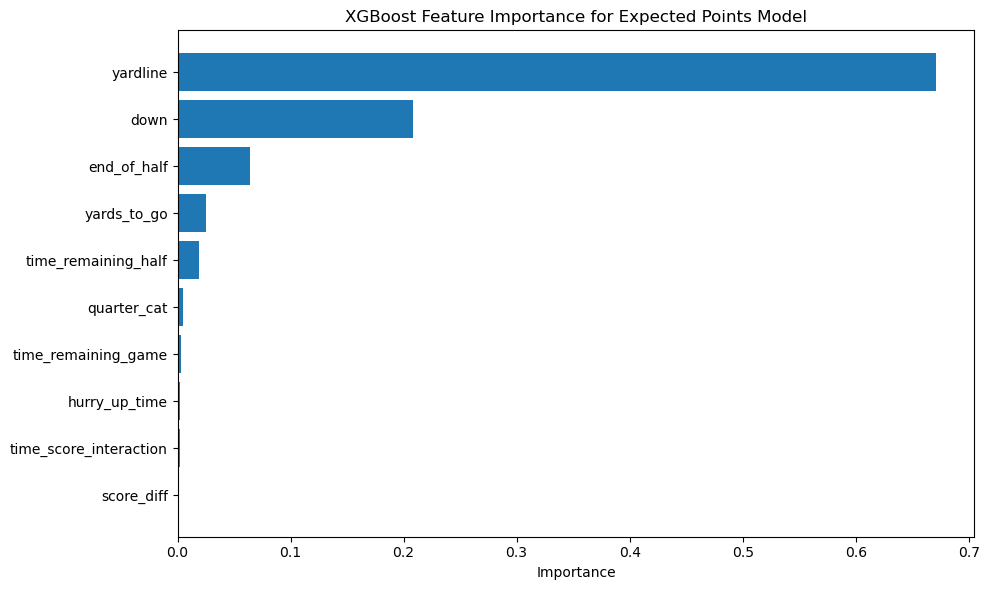


Model saved as 'ep_model.pkl'


In [31]:
# Get feature importance
import matplotlib.pyplot as plt

# Use the best model from grid search
best_model = grid_search.best_estimator_

# Get importance scores
importance_df = pd.DataFrame({
    'feature': features,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance:")
print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.title('XGBoost Feature Importance for Expected Points Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Save the model for future use
import pickle
with open('ep_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print("\nModel saved as 'ep_model.pkl'")

In [37]:
# Get predictions and calculate errors for the test set
y_pred = best_model.predict(X_test)
errors = y_test - y_pred

# Create a comprehensive error analysis dataframe
error_analysis = X_test.copy()
error_analysis['actual_EP'] = y_test.values
error_analysis['predicted_EP'] = y_pred
error_analysis['error'] = errors.values
error_analysis['abs_error'] = np.abs(errors.values)

# Sort by absolute error to find biggest misses
biggest_errors = error_analysis.sort_values('abs_error', ascending=False).head(20)

print("20 Biggest Prediction Errors:")
print(biggest_errors)

# Analyze positive vs negative errors separately
print("\n" + "="*80)
print("10 Biggest OVERPREDICTIONS (model predicted too high):")
overpredictions = error_analysis.sort_values('error', ascending=False).head(10)
print(overpredictions[['down', 'yards_to_go', 'yardline', 'score_diff', 'end_of_half', 
                        'actual_EP', 'predicted_EP', 'error']])

print("\n" + "="*80)
print("10 Biggest UNDERPREDICTIONS (model predicted too low):")
underpredictions = error_analysis.sort_values('error', ascending=True).head(10)
print(underpredictions[['down', 'yards_to_go', 'yardline', 'score_diff', 'end_of_half',
                         'actual_EP', 'predicted_EP', 'error']])

# Summary statistics of errors
print("\n" + "="*80)
print("Error Distribution Summary:")
print(f"Mean error: {errors.mean():.4f}")
print(f"Median absolute error: {np.median(np.abs(errors)):.4f}")
print(f"95th percentile absolute error: {np.percentile(np.abs(errors), 95):.4f}")
print(f"Max absolute error: {np.abs(errors).max():.4f}")

20 Biggest Prediction Errors:
      down  yards_to_go  yardline  score_diff  time_remaining_game  \
15628    3            4        55           8                 2911   
4884     3           10        21           0                 2848   
11711    2            3         4           3                  925   
293      3           10        39           3                 2820   
15536    3            6        45           6                 2820   
7048     3            1        17         -14                 2916   
6388     4            2        36          12                 2820   
14176    3           21        38           0                 2762   
12525    3            7        86           0                  797   
13389    1           10        54          -1                 2773   
11723    1           10        35          21                  962   
7791     2            7        28           4                  930   
7014     1           10        26         -14               

In [ ]:
# Select the columns needed for EP predictions + identifiers
ep_features_to_save = [
    'game_id', 'play_id',  # Identifiers for merging
    'down', 'yards_to_go', 'yardline', 'score_diff',  # Core features
    'time_remaining_game', 'time_remaining_half', 'end_of_half', 
    'hurry_up_time', 'time_score_interaction', 'quarter_cat',  # Time features
]

# Save the dataframe
df[ep_features_to_save].to_csv('ep_model_features.csv', index=False)